# Reviewing Regression!

This notebook is meant to serve as a broad review of major regression concepts and models. It assumes that you've seen all of these concepts and models before and is framed around a series of review questions / possible interview questions, divided into several sections.

1. **Basics**: OLS linear regression and evaluation
2. **Intermediate**: Linear regression assumptions, model tuning/complexity tradeoffs; regularization, polynomial terms
3. **Beyond OLS**: Tree methods; random forest and gradient boosting

Remeber this spreadsheet of model review questions and pro/con breakdowns as well!
https://docs.google.com/spreadsheets/d/1LLcGQLWkA3JC_U5hDr9b2XYdvfqtJiDQq7xQu5nBe_g/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Basics

1) **Explain OLS regression.** What is the basic functional form? How do we find the model parameters? What is a cost function?

OLS regression models a continuous target variable $y$ as a **linear combination** of features $x_1, ..., x_p$ plus a bias term (intercept) and random noise.

$$ y = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p + \epsilon $$

The parameters of the model are the coefficients $\beta_i$, and we find them by minimizing a cost function, a function of the parameters that describes how well the model fits the observed data. There are multiple choices of cost function, but the most common one / the one used for OLS is **squared error loss** i.e:

$$ J(\beta_0, ..., \beta_p) = \sum_{1}^{n} (y_i - (\beta_0 + \beta_1 x_1 + ... + \beta_p x_p))^2 $$

The **normal equations** give a closed form, linear algebra solution for the parameters that minimize this cost function. However, we often prefer to train models with the optimization method **gradient descent**, since it can be computationally faster and solves a more general class of problems. With this method, we repeatedly iterate through the training data to calculate the gradient of the cost function with respect to the parameter vector, updating the parameter vector by taking a small step in the direction opposite to the gradient.   

For more details and the math on both check out [Andrew Ng's excellent course notes](http://cs229.stanford.edu/notes/cs229-notes1.pdf)

2) **Once we've trained an OLS/regression model, how would we evaluate its quality**? 

The true answer to this always depends on the problem domain / business needs. But there are a few commonly used metrics that are good to remember like the "coefficient of determination" **R^2** and **RMSE** (root mean squared error).

R^2 measures how much better your predictions are than predicting the mean of the target. Negative R^2 implies your model is worse than predicting the mean, while positive implies better than the mean (the max value is 1, with perfect predictions). It is also commonly thought of as "percent of variance explained".

RMSE is a nice way to quantify your error on the original unit scale of the problem (e.g. if you're predicting movie budget, RMSE of $20 means you tend to be off by that much.

Here is code defining these evaluation metrics, note that $R^2 = 1 - SSE / SST$

In [2]:
def SSE(actuals, preds): # sum of squared errors
    return np.sum((actuals - preds)**2)

def SST(y): # total sum of the squares (differences from mean)
    return np.sum((y - np.mean(y))**2)

def R2(actuals, preds):
    return 1 - SSE(actuals, preds) / SST(actuals)

In [3]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

## Intermediate

1) **Give some of the assumptions of OLS regession**. How can we diagnose if they are met? What can go wrong if we violate them? How can we fit a model to data that doesn't meet them?

* Regression is linear in parameters & correctly specified i.e. $E[y | x] = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p$ for some collection of beta coefficients 
* The error terms are normally distributed and zero population mean
* The error term has constant variance $Var({\epsilon_i})={\sigma^2}$ for every i (no heteroskedasticity)
* Errors are uncorrelated across observations: $cov({\epsilon_i},{\epsilon_j})=0$ for two observations i and j (no serial correlation)
* No independent variables are multicolinear with the other independent variables, or if there is multicolinearity it is minimal

There are a lot of great **diagnostic plots** we can look to for analyzing if the assumptions are met. In the example below, we can look at the **regression fit** plot to check that the model is correctly specified, the **residual plot** to check for heteroskedasticity, and the **Q-Q** plot to check for normality of the residuals.

We can also get a quantitative measure of multicolinearity in the data matrix through the condition number.

Check out [this notebook](https://github.com/thisismetis/nyc18_ds17/blob/master/class_lectures/week03-luther2/01-assumptions/Linear_Assumptions_testing.ipynb) for even more detail on what we can look at to diagnose assumption failures. 

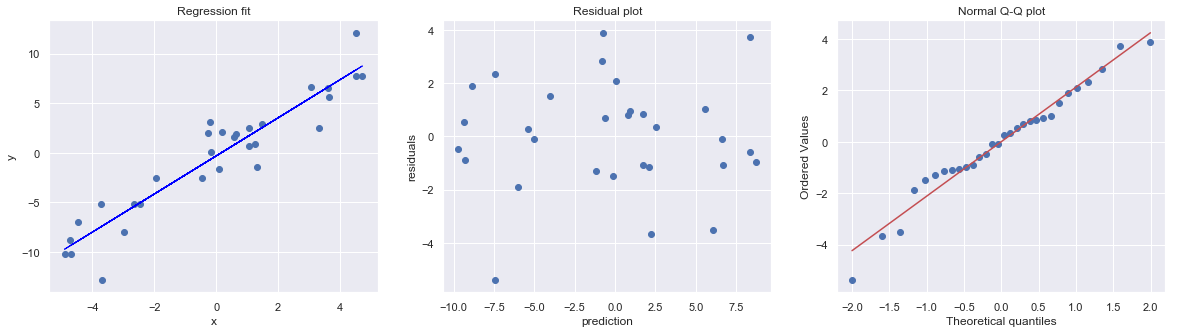

In [4]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    
# Generate some data
s = 30
x = np.random.uniform(low=-5, high=5, size=s)

ep = 2*np.random.randn(s)
beta = 2
y = beta*x + ep

diagnostic_plot(x, y)

Violating the regression assumptions need not be the end of the world. Our model may not be ideal, but it may still work ok, especially if our features tend to have **monotonic** (i.e. single-directional) relationships with the target. We can always evaluate our model with R^2 or RMSE on validation/test data.

If the model just doesn't work, the fix will depend on the nature of the problem. If we have a high degree of feature multicolinearity, regularization may be called for. If we are failing to capture non-monotonic relationships or interactions, a polynomial regression or more advanced non-linear model (e.g. tree-based methods) may be called for. 

2) **What is regularization?** How does it relate to cost functions? What problems can it solve? What is L1 vs. L2 or Lasso vs. Ridge regularization?  

In linear regression, regularization imposes a penalty on the magnitude of the regression coefficients, directly incorporating this penalty into the cost function. This penalty has the effect of encouraging the coefficients to be closer to 0 so that the cost function is also smaller, preventing the coefficients from becoming too extreme. In **L2 or ridge regression**, the cost function becomes the below (punishing sum of squared coefficients with regularization strength lambda). We typically choose lambda through validation/cross-validation.

$$ J(\beta_0, ..., \beta_p) = \sum_{1}^{n} (y_i - (\beta_0 + \beta_1 x_1 + ... + \beta_p x_p))^2 + \lambda \sum_{0}^{p}\beta_i^2$$

**Regularization makes models higher bias but lower variance**, helping improve a model if it is overfit. **It also helps with multicolinearity** by smoothing out coefficients of colinear variables to be similar (ridge) or bringing one of them to 0 (lasso). 

The lasso penalty is given by:  

$$ J(\beta_0, ..., \beta_p) = \sum_{1}^{n} (y_i - (\beta_0 + \beta_1 x_1 + ... + \beta_p x_p))^2 + \lambda \sum_{0}^{p} 
\mid\beta\mid$$

A major difference between ridge and lasso is that ridge will never truly zero out features, while lasso will perform a feature selection role if the regularization strength $\lambda$ is high enough.

3) **How can we fix a linear regression model if it's underfitting?** How can we capture feature interactions with a linear regression model? How does polynomial regression work?

Recall the [linear regression wrap-up notebook](https://github.com/thisismetis/nyc18_ds17/blob/master/class_lectures/week03-luther2/03-review_workflow/linear_regression_interp_interactions.ipynb).

Beyond doing more feature engineering, looking for more data, or trying a more advanced model, we can make an underfit linear regression more complex by **adding interaction and polynomial terms**. Our model still gives a linear combination of features, but we're now using features for interactions and higher order terms.

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_1 x_2 + \beta_4 x_1^2 + \beta_5 x_2^2 + \epsilon $$

This lets us capture more complex relationships - both nonlinear relationships and interactive relationships between different features. The complexity of the polynomial regression fit is determined by the degree of the polynomial (higher degree = more complex). 

## Beyond Linear Regression

1) **When would we use a tree-based method** in a regression problem? What are the pros and cons?

When we want to model a nonlinear relationship, care most about predictive accuracy vs. interpretability, and don't have computational constraints, **Tree Based Methods** like random forest and gradient boosting have many nice benefits:

* Automatically model feature interactions
* Automatically model nonlinear relationships between features and target (no need for all the polynomial terms)
* Automatically select features / robust to useless features
* Robust to feature outliers
* Scale invariant (no need to standardize!)
* Natural handling of NA values

The major con of these models is that they are significantly harder to interpret than linear models / lack their clear explanability (they do have feature importance scores, but these don't give direct insight into the directional relationship between features and the target). They are also more computationally expensive.

2) **Explain the algorithm behind decision trees**

Recall the [classification tree splitting notebook](https://github.com/thisismetis/nyc18_ds17/blob/master/class_lectures/week05-mcnulty2/01-trees_FE/Classification_Tree_Splitting.ipynb).

* Choose a measure of node impurity $I$, usually *variance* in the regression setting. For a split that partitions a node along a particular feature value, we define **information gain** as 

$$ I(parent) - (\frac{n_{l}}{N} I(child_{l}) + \frac{n_{r}}{N} I(child_{r}))$$ 

* I.e. information gain is the difference between the impurity of a node and the weighted sum of the impurity of its children. For each split, we're trying to reduce impurity as much as possible to separate data points as effectively as possible.

* Until we reach a maximum depth, maximum leaves, minimum information gain etc. stopping point:

    * For every feature:
        * For every value in feature:
            * compute info gain from splitting on that feature, track best
    * Split on best feature/value
    * Recursively split both children

3) **Explain the algorithm behind random forest**

* We exploit an ensemble method to **reduce the variance of a strong learner** (decision tree) by averaging over many relatively uncorrelated copies of that model.

* For each base model tree, we draw a **bootstrap sample** of the training data (sampling with replacement from the rows), and for each decision tree split we draw a **random subsample of the features** to consider as selections for splitting. A typical choice of features to subsample is $\sqrt(p)$ where $p$ is the number of features. These sources of randomness help to reduce the correlation between each tree in the forest.

* We do this for $n$ base trees (hyperparameter), and make predictions by averaging over all $n$ base trees.

4) **Explain the algorithm behind gradient boosted trees**

Recall the [gradient boosting notebook](https://github.com/thisismetis/nyc18_ds17/blob/master/class_lectures/week05-mcnulty2/02-boosting/GradientBoostedTrees_xgboost.ipynb).

The idea behind gradient boosting is to **ensemble in a way that exploits dependence instead of independence** (the approach that RF takes). Specifically, at each step we train a base learner that **learns how to correct for mistakes made by the model we've built so far**, adding that new learner to the collection. We generate predictions by summing across the entire collection at the end.

In (mostly) english, here's what we do:

* We'll train $k$ (hyperparameter) base learner decision trees with max depth $d$ (hyperparameter) step by step, adding each to our overall model.
* Each base tree is fit using our data $X$, but the target values are the residuals $y - model_{cur}$, where $model_{cur}$ is our overall model at that time step (sum of previous trees and initialization)  
* We initialize our model with the best constant prediction, $mean(y)$.   

As an algorithm:

1. Set $T_0 = mean(y)$
2. For $m = 1,...,k$:
    1. Set $r_{m-1} = y - (T_0 + \sum\limits_{j=1}^{m-1}T_j(X))$
    2. Fit max depth $d$ tree $T_m$ with features $X$, target $r_{m-1}$
  
Obtain final model: $F(X) = T_0 + T_1(X) + ... + T_k(X)$